## Villin Headpiece HP35 - hdbMSM

Here we use the fast folding (Nle/Nle)-mutant of Villin Headpiece HP35, specifically two trajectories previously run by Shaw group, to build a Markov State Model with the hdbMSM procedure introduced in Mitxelena et al. JCP 2021.

The first thing one must do is request the data from Shaw group, since they we do not have license to share them, and then import a number of libraries we will need as we run this example, most unusual dependencies are listed in repo's README.

In [2]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import sys
from itertools import combinations
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

### File format modifications (only in the first run)

In [ ]:
# join trajectories
trajfile = "pnas2012-2f4k-360K-protein/pnas2012-2f4k-360K-protein-%s.dcd"
traj_join = md.join([md.load_dcd(trajfile%("%s"%x).zfill(3), \
                    stride=10, top="./system.pdb") for x in range(152)])
                    

In [ ]:
traj_join.save_dcd("./2F4K_join.dcd")

Trajectory and Topology analysis

In [3]:
traj_join = md.load_dcd("./2F4K_join.dcd", \
                   top="pdb/system.pdb")
                    #top="./pdb/2f4k.pdb")

In [4]:
traj_join

<mdtraj.Trajectory with 152000 frames, 577 atoms, 70 residues, and unitcells at 0x7f14652e4d50>

In [5]:
topology = traj_join.topology
table, bonds = topology.to_dataframe()
table.to_csv('topo.csv')
print(table.head())

   serial name element  resSeq resName  chainID segmentID
0       1    N       N      42     LEU        0        C1
1       2   CA       C      42     LEU        0        C1
2       3   CB       C      42     LEU        0        C1
3       4   CG       C      42     LEU        0        C1
4       5  CD1       C      42     LEU        0        C1


In [6]:
topology.n_atoms, topology.n_residues

(577, 70)

In [7]:
dists, residue_pairs = md.compute_contacts(traj_join, contacts='all', scheme='ca')

Choose a reference to compute RMSD and Q

In [59]:
mol = md.load("pdb/2f4k.pdb")
# if 3.gro corresponds to a snapshot of the folded state:
mol = md.load("snapshots/3.gro")

In [60]:
rmsds = md.rmsd(traj_join, mol)

Text(0.5, 0, 'frames')

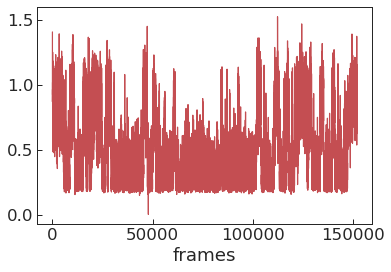

In [61]:
plt.figure();
plt.plot(traj_join.time, rmsds, 'r', label='all atom')
plt.xlabel('frames')

In [62]:
def best_hummer_q(traj, native):
    """Compute the fraction of native contacts according the definition from
    Best, Hummer and Eaton [1]
    
    Parameters
    ----------
    traj : md.Trajectory
        The trajectory to do the computation for
    native : md.Trajectory
        The 'native state'. This can be an entire trajecory, or just a single frame.
        Only the first conformation is used
        
    Returns
    -------
    q : np.array, shape=(len(traj),)
        The fraction of native contacts in each frame of `traj`
        
    References
    ----------
    ..[1] Best, Hummer, and Eaton, "Native contacts determine protein folding
          mechanisms in atomistic simulations" PNAS (2013)
    """
    
    BETA_CONST = 50  # 1/nm
    LAMBDA_CONST = 1.8
    NATIVE_CUTOFF = 0.45  # nanometers
    
    # get the indices of all of the heavy atoms
    heavy = native.topology.select_atom_indices('heavy')
    # get the pairs of heavy atoms which are farther than 3
    # residues apart
    heavy_pairs = np.array(
        [(i,j) for (i,j) in combinations(heavy, 2)
            if abs(native.topology.atom(i).residue.index - \
                   native.topology.atom(j).residue.index) > 3])
    
    # compute the distances between these pairs in the native state
    heavy_pairs_distances = md.compute_distances(native[0], heavy_pairs)[0]
    # and get the pairs s.t. the distance is less than NATIVE_CUTOFF
    native_contacts = heavy_pairs[heavy_pairs_distances < NATIVE_CUTOFF]
    print("Number of native contacts", len(native_contacts))
    
    # now compute these distances for the whole trajectory
    r = md.compute_distances(traj, native_contacts)
    # and recompute them for just the native state
    r0 = md.compute_distances(native[0], native_contacts)
    
    q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)
    return q  

Number of native contacts 499


/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in exp


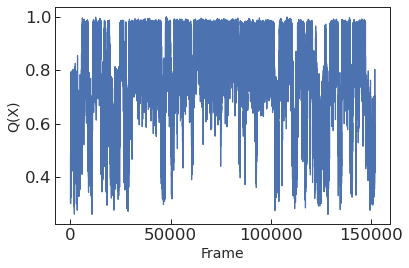

In [63]:
q = best_hummer_q(traj_join, mol)
plt.plot(q)
plt.xlabel('Frame', fontsize=14)
plt.ylabel('Q(X)', fontsize=14)
plt.show()

### Analysis

In [5]:
traj = traj_join

In [6]:
import pyemma
pyemma.__version__

'2.5.7'

In [7]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt

In [8]:
topfile = "./system.pdb"
feat = coor.featurizer(topfile)

In [11]:
feat.add_distances_ca(excluded_neighbors=0)

In [12]:
ca = feat.select_Ca()
ca

array([  1,   9,  15,  23,  32,  40,  51,  60,  65,  72,  83,  87,  95,
       102, 113, 119, 124, 135, 140, 148, 156, 163, 171, 185, 193, 202,
       211, 221, 229, 237, 246, 255, 264, 268, 276])

In [13]:
feat.add_inverse_distances(ca)

28-01-22 09:46:58 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  The 1D arrays input for add_inverse_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features


In [15]:
feat.describe()[:10]

['DIST: LEU 42 CA 1 - SER 43 CA 9',
 'DIST: LEU 42 CA 1 - ASP 44 CA 15',
 'DIST: LEU 42 CA 1 - GLU 45 CA 23',
 'DIST: LEU 42 CA 1 - ASP 46 CA 32',
 'DIST: LEU 42 CA 1 - PHE 47 CA 40',
 'DIST: LEU 42 CA 1 - LYS 48 CA 51',
 'DIST: LEU 42 CA 1 - ALA 49 CA 60',
 'DIST: LEU 42 CA 1 - VAL 50 CA 65',
 'DIST: LEU 42 CA 1 - PHE 51 CA 72',
 'DIST: LEU 42 CA 1 - GLY 52 CA 83']

In [16]:
inp = coor.source(["./2F4K_join.dcd"], feat)

In [17]:
print ('number of trajectories = ', inp.ntraj)
print('trajectory length = ',inp.trajectory_length(0))
print('number of dimension = ',inp.dimension())

number of trajectories =  1
trajectory length =  152000
number of dimension =  1190


In [18]:
lag= 5  #20 #2
tica_obj = coor.tica(inp, lag=lag, var_cutoff=0.9, kinetic_map=True)
print('TICA dimension ', tica_obj.dimension())

TICA dimension  360


In [19]:
tica_obj.cumvar[:10]

array([0.01180154, 0.02309773, 0.03372501, 0.04400498, 0.05394015,
       0.06370823, 0.07320541, 0.08216424, 0.09086718, 0.09938369])

In [20]:
dim=3
tica_obj = coor.tica(inp, lag=lag, dim=dim, kinetic_map=True) #dim=5

In [21]:
len(tica_obj.eigenvectors),len(tica_obj.eigenvalues),tica_obj.describe(),tica_obj.eigenvalues[:5]#,tica_obj.eigenvectors[:,1]

(1190,
 1155,
 '[TICA, lag = 5; max. output dim. = 3]',
 array([0.9870598 , 0.96569472, 0.93666677, 0.92123426, 0.90565238]))

In [22]:
tica_output = tica_obj.get_output()

In [23]:
Y0 = tica_obj.get_output()[0]
print('Projected data shape = ', Y0.shape)
Y0.shape

Projected data shape =  (152000, 3)


(152000, 3)

In [8]:
import h5py
h5file = "tica_%g_%g.h5"%(lag, dim)
with h5py.File(h5file, "w") as ycum:
    ycum.create_dataset("tica", data=Y0)

NameError: name 'lag' is not defined

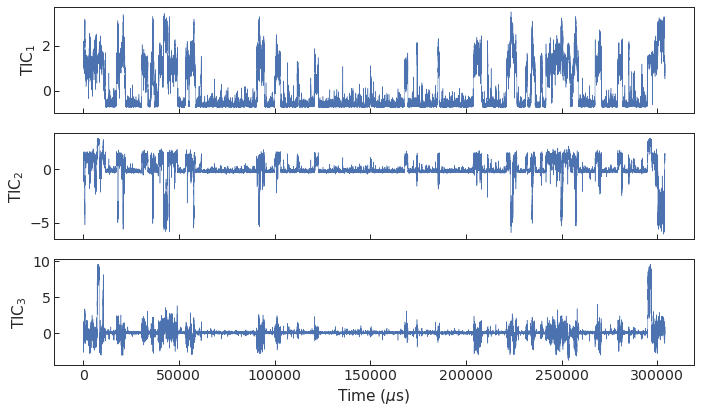

In [25]:
xaxis = np.arange(0,152e3,1)
xaxis = xaxis/0.5
sns.set_context('paper', font_scale=1.6)
fig, ax = plt.subplots(3,1, figsize=(10,6), sharex=True)
for i in range(3):
    #ax[i][0].plot(traj.time, Y0[:,i], lw=0.5)
    ax[i].plot(xaxis, Y0[:,i], lw=0.5)
    ax[i].set_ylabel('TIC$_%g$'%(i+1))
ax[-1].set_xlabel('Time ($\mu$s)')
plt.tight_layout()
#plt.savefig("tica-5-3.png",dpi=300,transparent=True)

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


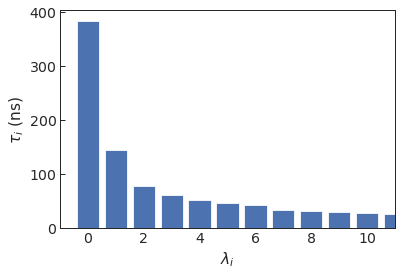

In [26]:
fig, ax = plt.subplots()
ax.bar(range(len(tica_obj.eigenvalues)), -lag/np.log(tica_obj.eigenvalues))
ax.set_xlabel('$\lambda_i$')
ax.set_ylabel(r'$\tau_i$ (ns)')
ax.set_xlim(-1,11)
plt.tight_layout
#plt.savefig("tica-5-3-eigs.png",dpi=300,transparent=True)

### Load TICA traj from file (if this is not your first run)

In [12]:
import h5py
#h5file = "./c-alpha-and-inverses/lag-tica-20/tica_20_3.h5"
h5file = "./tica_5_3.h5"
f = h5py.File(h5file, 'r')
Ycum = np.array(f['tica'])
f.close()    

### Traditional MSM construction

In [28]:
k=1000
cl = coor.cluster_kmeans(data=[Ycum[:,0:3]], k=k, max_iter=1000)#Y0[:,0:2], Y1,stride=5, k=100
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]
cc_z = cl.clustercenters[:,2]

In [29]:
h5file = "kmeans_%g.h5"%k
with h5py.File(h5file, "w") as traj:
    traj.create_dataset("kmeans", data=dtrajs)

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


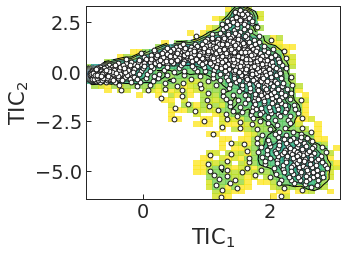

In [23]:
sns.set_context('paper', font_scale=2.2)
fig, ax = plt.subplots(figsize=(5,4))
# histogram data
counts, ybins, xbins, image = ax.hist2d(Ycum[:,0],Ycum[:,1], \
                bins=[40,40], cmap='viridis_r', \
                norm=mpl.colors.LogNorm(), density=True, alpha=0.8)
ax.contour(np.transpose(np.log(counts)), extent=[ybins.min(), ybins.max(), \
            xbins.min(), xbins.max()], linewidths=1, cmap=cm.binary_r, levels = np.arange(-6,4,1))
ax.plot(cc_x,cc_y, linewidth=0, marker='o', mfc='w', mec='k')
ax.set_xlabel('TIC$_1$'),ax.set_ylabel('TIC$_2$')
plt.tight_layout()
#plt.savefig("kmeans-1000.png",dpi=300,transparent=True)

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


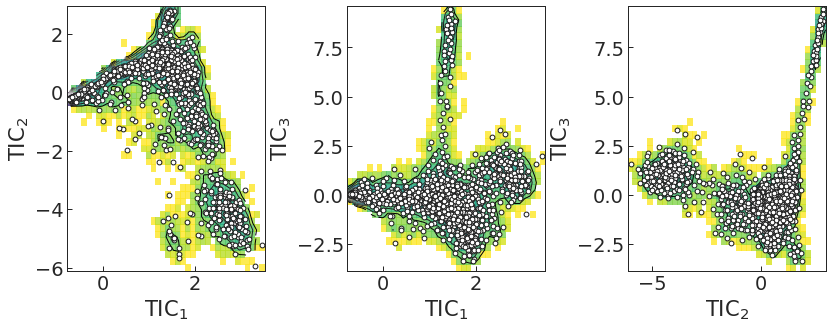

In [30]:
sns.set_context('paper', font_scale=2.2)
fig, ax = plt.subplots(1,3,figsize=(12,5))
# histogram data
counts, ybins, xbins, image = ax[0].hist2d(Ycum[:,0],Ycum[:,1], \
                bins=[40,40], cmap='viridis_r', \
                norm=mpl.colors.LogNorm(), density=True, alpha=0.8)
ax[0].contour(np.transpose(np.log(counts)), extent=[ybins.min(), ybins.max(), \
                                         xbins.min(), xbins.max()], \
                  linewidths=1, cmap=cm.binary_r, levels = np.arange(-6,4,1))
ax[0].plot(cc_x,cc_y, linewidth=0, marker='o', mfc='w', mec='k')
ax[0].set_xlabel('TIC$_1$'),ax[0].set_ylabel('TIC$_2$')
# plot 2
counts, ybins, xbins, image = ax[1].hist2d(Ycum[:,0],Ycum[:,2], \
                bins=[40,40], cmap='viridis_r', \
                norm=mpl.colors.LogNorm(), density=True, alpha=0.8)
ax[1].contour(np.transpose(np.log(counts)), extent=[ybins.min(), ybins.max(), \
                                         xbins.min(), xbins.max()], \
                  linewidths=1, cmap=cm.binary_r, levels = np.arange(-6,4,1))
ax[1].plot(cc_x,cc_z, linewidth=0, marker='o', mfc='w', mec='k')
ax[1].set_xlabel('TIC$_1$'),ax[1].set_ylabel('TIC$_3$')
# plot 3
counts, ybins, xbins, image = ax[2].hist2d(Ycum[:,1],Ycum[:,2], \
                bins=[40,40], cmap='viridis_r', norm=mpl.colors.LogNorm(), density=True, alpha=0.8)
ax[2].contour(np.transpose(np.log(counts)), extent=[ybins.min(), ybins.max(), \
                xbins.min(), xbins.max()], linewidths=1, cmap=cm.binary_r, levels = np.arange(-6,4,1))
ax[2].plot(cc_y,cc_z, linewidth=0, marker='o', mfc='w', mec='k')
ax[2].set_xlabel('TIC$_2$'),ax[2].set_ylabel('TIC$_3$')
plt.tight_layout()
#plt.savefig("kmeans-1000.png",dpi=300,transparent=True)

In [32]:
lags = [1,5,10,25,50,100]
#lags = range(1,50,5)
its = msm.its(dtrajs, lags=lags, errors='bayes')

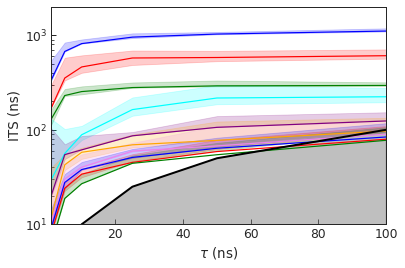

In [34]:
sns.set_context('paper', font_scale=1.4)
mplt.plot_implied_timescales(its, nits=10, show_mean=False, ylog=True, units='ns') #, dt=20
#plt.ylim(0,7000) ylog=False
plt.ylim(10,2e3)
plt.ylabel('ITS (ns)')
plt.xlabel(r'$\tau$ (ns)')
#plt.savefig("kmeans-1000-its.png",dpi=300,transparent=True)

In [35]:
M = msm.bayesian_markov_model(dtrajs, 30, dt_traj='2 ns')

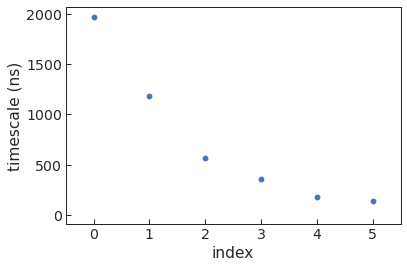

In [36]:
sns.set_context('paper', font_scale=1.6)
plt.plot(M.timescales(),linewidth=0,marker='o')
plt.xlabel('index')
plt.ylabel('timescale (ns)')
plt.xlim(-0.5,5.5)#,plt.ylim(1e2,1e3)
#plt.yscale('log')
#plt.savefig("pcca-times.png",dpi=300,transparent=True)

In [37]:
M.pcca(4)
pcca_dist = M.metastable_distributions

In [38]:
pcca_sets = M.metastable_sets

In [39]:
len(pcca_sets)

4

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


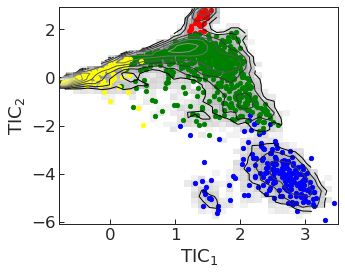

In [40]:
sns.set_context('paper', font_scale=1.9)
fig, ax = plt.subplots(1,figsize=(5,4))
# histogram data
counts, ybins, xbins, image = ax.hist2d(Ycum[:,0],Ycum[:,1], \
                bins=[40,40], cmap='binary', \
                norm=mpl.colors.LogNorm(), density=True, alpha=0.8)
ax.contour(np.transpose(np.log(counts)), extent=[ybins.min(), ybins.max(), \
            xbins.min(), xbins.max()], linewidths=1, cmap=cm.binary_r, levels = np.arange(-6,4,1))
ax.scatter(cl.clustercenters[pcca_sets[0],0], cl.clustercenters[pcca_sets[0],1], color='red', s=20)
ax.scatter(cl.clustercenters[pcca_sets[1],0], cl.clustercenters[pcca_sets[1],1], color='blue', s=20)
ax.scatter(cl.clustercenters[pcca_sets[2],0], cl.clustercenters[pcca_sets[2],1], color='green', s=20)
ax.scatter(cl.clustercenters[pcca_sets[3],0], cl.clustercenters[pcca_sets[3],1], color='yellow', s=20)
ax.set_xlabel('TIC$_1$'), ax.set_ylabel('TIC$_2$')
#plt.savefig("pcca.png",dpi=300,transparent=True)

### Exploting density by HDBSCAN (hdbMSM)

In [13]:
import hdbscan

In [14]:
np.shape(Ycum[:,0:3])

(152000, 3)

In [15]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(Ycum)

In [16]:
min_cluster_size, min_samples = 50, 80
hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
                      min_samples=min_samples).fit(X)  #,min_samples=50

In [17]:
np.unique(hdb.labels_)

array([-1,  0,  1,  2,  3,  4,  5])

<AxesSubplot:ylabel='$\\lambda$ value'>

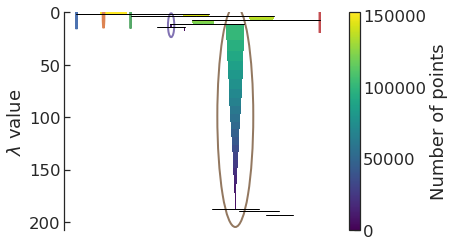

In [18]:
hdb.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
#plt.savefig("hdbscan-tree-%g_%g.png"%(min_cluster_size, min_samples),dpi=300,transparent=True)

(Text(0.5, 0, 'TIC$_1$'), Text(0, 0.5, 'TIC$_2$'))

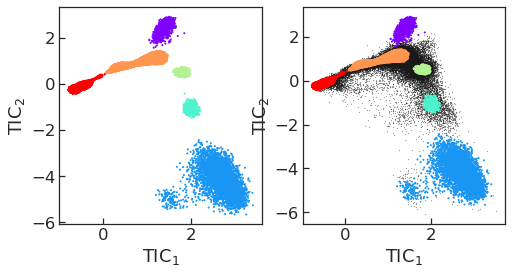

In [19]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
# histogram data
assign = hdb.labels_ >= 0
nassign = hdb.labels_ == -1
ax[0].scatter(Ycum[assign,0],Ycum[assign,1], marker='o', 
                cmap='rainbow', s=1, c=hdb.labels_[assign])
ax[0].set_xlabel('TIC$_1$'), ax[0].set_ylabel('TIC$_2$')
ax[1].scatter(Ycum[nassign,0],Ycum[nassign,1], marker='.', 
                cmap='rainbow', s=0.1, c='k')
ax[1].scatter(Ycum[assign,0],Ycum[assign,1], marker='o', 
                cmap='rainbow', s=1, c=hdb.labels_[assign])
ax[1].set_xlabel('TIC$_1$'), ax[1].set_ylabel('TIC$_2$')

In [20]:
for i, x_i in enumerate(hdb.labels_):
    if hdb.probabilities_[i] < 0.2:
        hdb.labels_[i] = -1
assign = hdb.labels_>= 0
nassign = hdb.labels_ < 0

((-1.0, 3.3), (-6.0, 5.0))

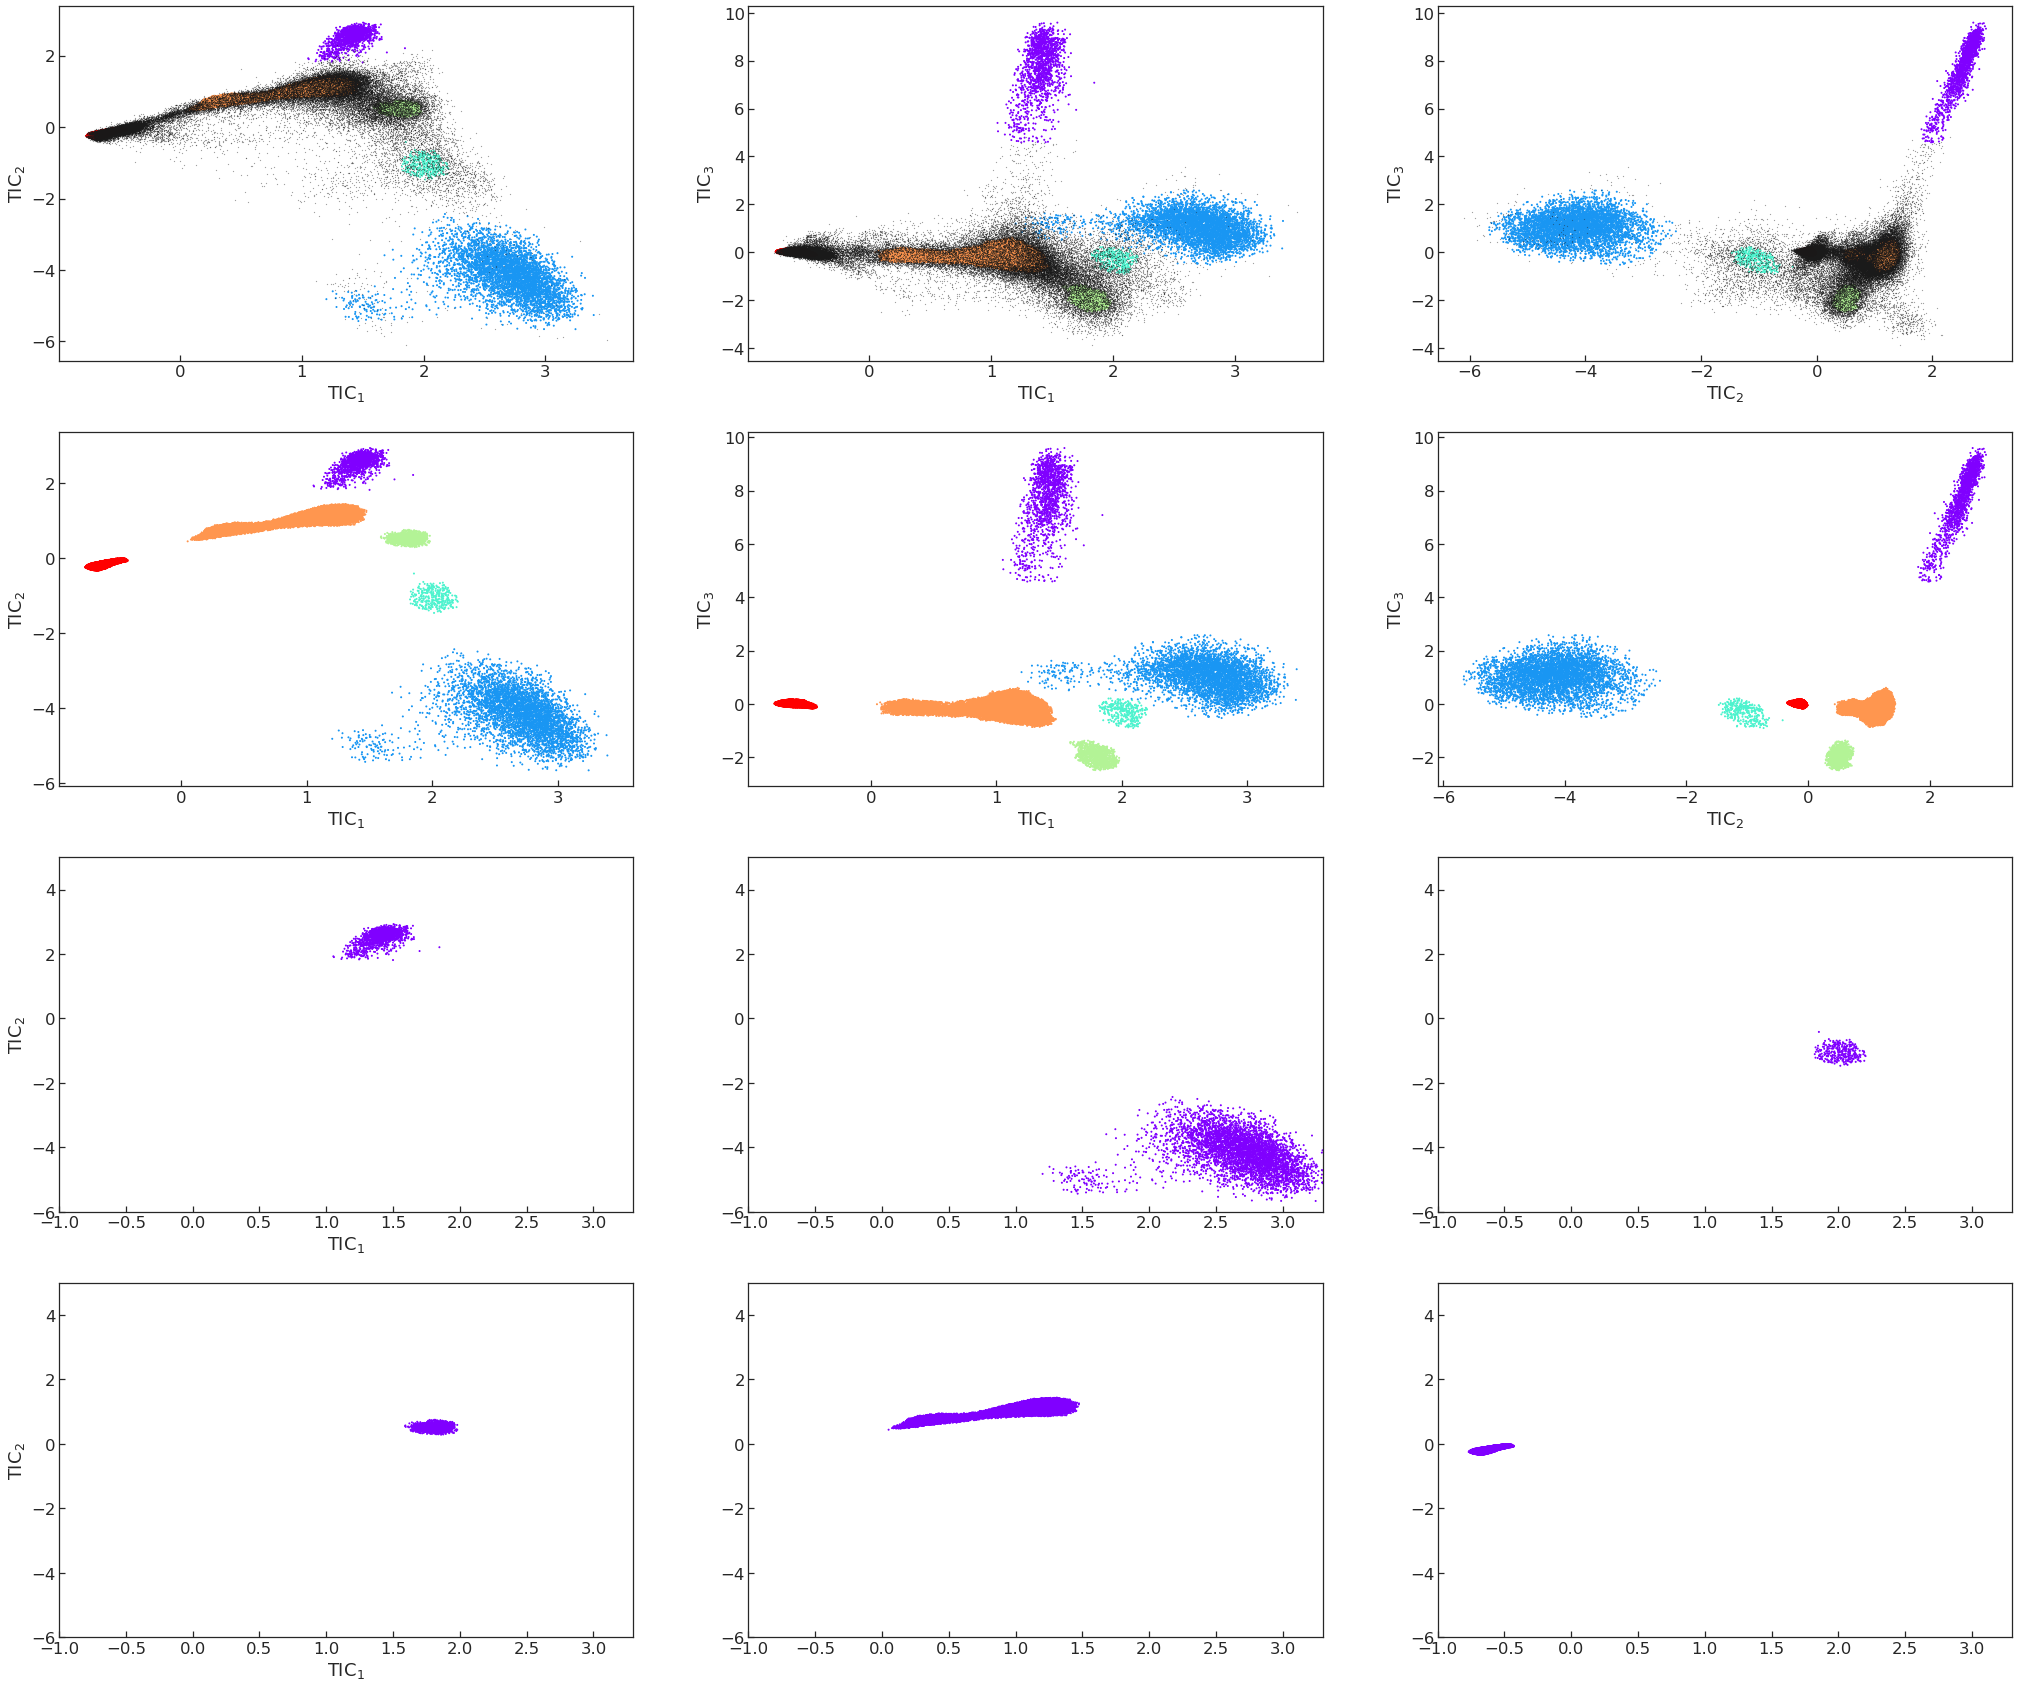

In [21]:
# THIS IS JUST TO IDENTIFY LABELS IN THE TICA SPACE
fig, ax = plt.subplots(4,3,figsize=(35,30))
# histogram data
assign = hdb.labels_ >= 0
ax[0,0].scatter(Ycum[assign,0],Ycum[assign,1], marker='o', 
                cmap='rainbow', s=1, c=hdb.labels_[assign])
nassign = hdb.labels_ == -1
ax[0,0].scatter(Ycum[nassign,0],Ycum[nassign,1], marker='.', 
                cmap='rainbow', s=0.1, c='k')
ax[0,0].set_xlabel('TIC$_1$'), ax[0,0].set_ylabel('TIC$_2$')
ax[0,1].scatter(Ycum[assign,0],Ycum[assign,2], marker='o', 
                cmap='rainbow', s=1, c=hdb.labels_[assign])
ax[0,1].scatter(Ycum[nassign,0],Ycum[nassign,2], marker='.', 
                cmap='rainbow', s=0.1, c='k')
ax[0,1].set_xlabel('TIC$_1$'), ax[0,1].set_ylabel('TIC$_3$')
ax[0,2].scatter(Ycum[assign,1],Ycum[assign,2], marker='o', 
                cmap='rainbow', s=1, c=hdb.labels_[assign])
ax[0,2].scatter(Ycum[nassign,1],Ycum[nassign,2], marker='.', 
                cmap='rainbow', s=0.1, c='k')
ax[0,2].set_xlabel('TIC$_2$'), ax[0,2].set_ylabel('TIC$_3$')
# without noise
ax[1,0].scatter(Ycum[assign,0],Ycum[assign,1], marker='o', 
                cmap='rainbow', s=1, c=hdb.labels_[assign])
ax[1,0].set_xlabel('TIC$_1$'), ax[1,0].set_ylabel('TIC$_2$')
ax[1,1].scatter(Ycum[assign,0],Ycum[assign,2], marker='o', 
                cmap='rainbow', s=1, c=hdb.labels_[assign])
ax[1,1].set_xlabel('TIC$_1$'), ax[1,1].set_ylabel('TIC$_3$')
ax[1,2].scatter(Ycum[assign,1],Ycum[assign,2], marker='o', 
                cmap='rainbow', s=1, c=hdb.labels_[assign])
ax[1,2].set_xlabel('TIC$_2$'), ax[1,2].set_ylabel('TIC$_3$')
# identify cluster enummeration
assign = hdb.labels_ == 0
ax[2,0].scatter(Ycum[assign,0],Ycum[assign,1], marker='o',
                cmap='rainbow', s=1, c=hdb.labels_[assign])
ax[2,0].set_xlabel('TIC$_1$'), ax[2,0].set_ylabel('TIC$_2$')
ax[2,0].set_xlim(-1,3.3), ax[2,0].set_ylim(-6,5)
assign = hdb.labels_ == 1
ax[2,1].scatter(Ycum[assign,0],Ycum[assign,1], marker='o', 
                cmap='rainbow', s=1, c=hdb.labels_[assign])
ax[2,1].set_xlim(-1,3.3), ax[2,1].set_ylim(-6,5)
assign = hdb.labels_ == 2
ax[2,2].scatter(Ycum[assign,0],Ycum[assign,1], marker='o', 
                cmap='rainbow', s=1, c=hdb.labels_[assign])
ax[2,2].set_xlim(-1,3.3), ax[2,2].set_ylim(-6,5)
assign = hdb.labels_ == 3
ax[3,0].scatter(Ycum[assign,0],Ycum[assign,1], marker='o',
                cmap='rainbow', s=1, c=hdb.labels_[assign])
ax[3,0].set_xlabel('TIC$_1$'), ax[3,0].set_ylabel('TIC$_2$')
ax[3,0].set_xlim(-1,3.3), ax[3,0].set_ylim(-6,5)
assign = hdb.labels_ == 4
ax[3,1].scatter(Ycum[assign,0],Ycum[assign,1], marker='o', 
                cmap='rainbow', s=1, c=hdb.labels_[assign])
ax[3,1].set_xlim(-1,3.3), ax[3,1].set_ylim(-6,5)
assign = hdb.labels_ == 5
ax[3,2].scatter(Ycum[assign,0],Ycum[assign,1], marker='o', 
                cmap='rainbow', s=1, c=hdb.labels_[assign])
ax[3,2].set_xlim(-1,3.3), ax[3,2].set_ylim(-6,5)
#plt.savefig("hdbscan-%g_%g.png"%(min_cluster_size, min_samples),dpi=300,transparent=False)

(Text(0, 0.5, 'TIC$_2$'), Text(0.5, 0, 'frame'))

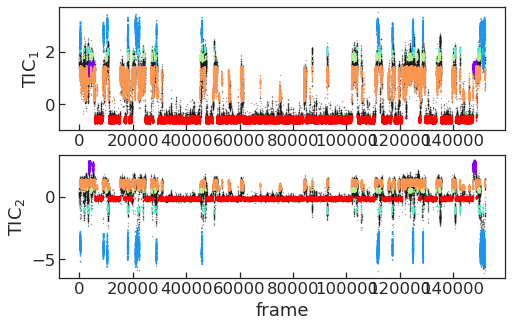

In [22]:
assign = hdb.labels_>= 0 
nassign = hdb.labels_ < 0
fig, ax = plt.subplots(2,1, figsize=(8,5))
ax[0].scatter(np.arange(len(Ycum[:,0]))[nassign], Ycum[nassign,0], s=0.15, c='k', alpha=0.5)
ax[0].scatter(np.arange(len(Ycum[:,0]))[assign], Ycum[assign,0], s=0.5, cmap=cm.rainbow, c=hdb.labels_[assign])
ax[0].set_ylabel('TIC$_1$')
ax[1].scatter(np.arange(len(Ycum[:,1]))[nassign], Ycum[nassign,1], s=0.15, c='k', alpha=0.5)
ax[1].scatter(np.arange(len(Ycum[:,1]))[assign], Ycum[assign,1], s=0.5, cmap=cm.rainbow, c=hdb.labels_[assign])
ax[1].set_ylabel('TIC$_2$'), ax[1].set_xlabel('frame')
#plt.savefig("hdbscan-trajs-%g_%g.png"%(min_cluster_size, min_samples),dpi=300,transparent=False)

In [23]:
def filter_labels(labels):
    x = []
    for l in labels:
        if l >= 0:
            x.append(l)
        else:
            try:
                x.append(x[-1])
            except IndexError:
                pass
    return x

In [24]:
hdbtrajs = filter_labels(hdb.labels_)

In [25]:
h5file = "hdbscan_%g_%g.h5"%(min_cluster_size, min_samples)
with h5py.File(h5file, "w") as traj:
    traj.create_dataset("hdbscan", data=hdbtrajs)

In [26]:
#lags = range(1,50,5)
lags = [1,5,10,25,50,100]
its = msm.its(hdbtrajs, lags=lags, errors='bayes')

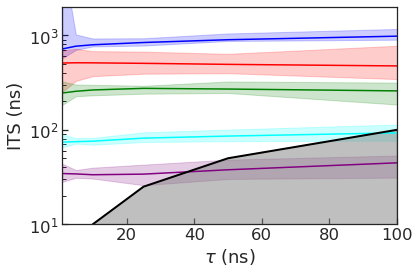

In [27]:
mplt.plot_implied_timescales(its, show_mean=False,nits=5)
plt.ylim(10,2e3)
plt.ylabel('ITS (ns)')
plt.xlabel(r'$\tau$ (ns)')
#plt.savefig("hdbscan-its-%g_%g.png"%(min_cluster_size, min_samples),dpi=300,transparent=False)

In [28]:
hdbM = msm.bayesian_markov_model(hdbtrajs, 40) #dt_traj='2 ns'

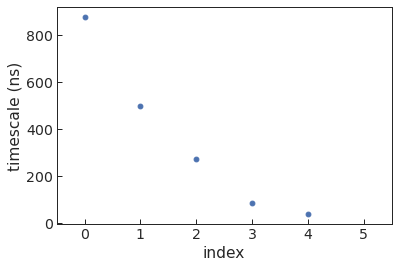

In [29]:
sns.set_context('paper', font_scale=1.6)
plt.plot(hdbM.timescales(),linewidth=0,marker='o')
plt.xlabel('index')
plt.ylabel('timescale (ns)')
plt.xlim(-0.5,5.5)#,plt.ylim(1e2,1e3)#plt.yscale('log')
#plt.savefig("hdb-times-%g_%g.png"%(min_cluster_size, min_samples),dpi=300,transparent=False)

The first eigenvector is one: True (min=0.9999999999999944, max=1.0000000000000164)


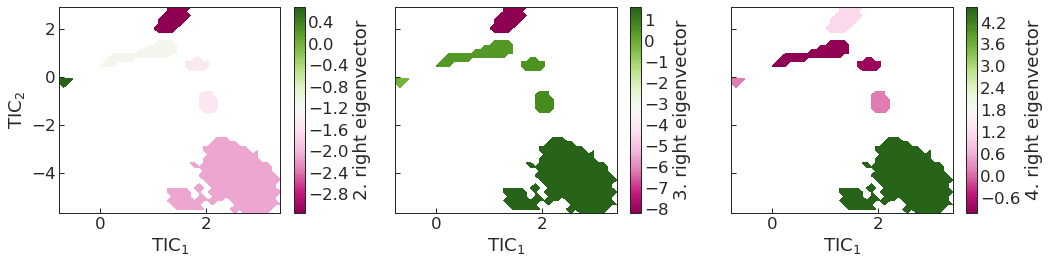

In [25]:
assign = hdb.labels_>= 0
hdb_eigvec = hdbM.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(hdb_eigvec[:, 0], 1, atol=1e-15), hdb_eigvec[:, 0].min(), hdb_eigvec[:, 0].max()))
sns.set_context('paper', font_scale=1.9)
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *Ycum[assign, :2].T,  # tica_concatenated[:, :2].T,
        hdb_eigvec[hdb.labels_[assign], i + 1], #eigvec[dtrajs_concatenated, i + 1],
        ax=ax,
        cmap='PiYG', #'PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2),
        mask=True, nbins=50,
        method='nearest', corner_mask=True)
    ax.set_xlabel('TIC$_1$')#, ax.set_xlim(-1.5,3.5)
axes[0].set_ylabel('TIC$_2$')
fig.tight_layout()
#plt.savefig("pcca-eigs.png",dpi=300,transparent=True)

Save snapshots for each cluster

In [67]:
traj2 = md.load_dcd("./2F4K_join.dcd", top="pdb/system.pdb")

In [69]:
len(hdb.labels_), len(traj2)

(152000, 152000)

In [70]:
for i in np.unique(hdb.labels_): #[1,3,19]:
    lab = np.where(hdb.labels_==i)
    snap = traj2[np.random.choice(lab[0])]
    snap.save_gro("snapshots/%s.gro"%i)